In [13]:
from tempfile import gettempdir
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import biotite.sequence as seq
import biotite.structure as struc
import biotite.structure.io as strucio
import biotite.structure.io.mmtf as mmtf
import biotite.database.rcsb as rcsb


In [14]:


def detect_disulfide_bonds(structure,       distance=2.05,      distance_tol=0.05,
                           dihedral=90,     dihedral_tol=10):
    # Array where detected disulfide bonds are stored
    disulfide_bonds = []
    # A mask that selects only S-gamma atoms of cysteins
    sulfide_mask = (structure.res_name == "CYS") & \
                   (structure.atom_name == "SG")
    # sulfides in adjacency to other sulfides are detected in an
    # efficient manner via a cell list
    cell_list = struc.CellList(
        structure,
        cell_size=distance+distance_tol,
        selection=sulfide_mask
    )
    # Iterate over every index corresponding to an S-gamma atom
    for sulfide_i in np.where(sulfide_mask)[0]:
        # Find indices corresponding to other S-gamma atoms,
        # that are adjacent to the position of structure[sulfide_i]
        # We use the faster 'get_atoms_in_cells()' instead of
        # `get_atoms()`, as precise distance measurement is done
        # afterwards anyway
        potential_bond_partner_indices = cell_list.get_atoms_in_cells(
            coord=structure.coord[sulfide_i]
        )
        # Iterate over every index corresponding to an S-gamma atom
        # as bond partner
        for sulfide_j in potential_bond_partner_indices:
            if sulfide_i == sulfide_j:
                # A sulfide cannot create a bond with itself:
                continue
            # Create 'Atom' instances
            # of the potentially bonds S-gamma atoms
            sg1 = structure[sulfide_i]
            sg2 = structure[sulfide_j]
            # For dihedral angle measurement the corresponding
            # C-beta atoms are required, too
            cb1 = structure[
                (structure.chain_id == sg1.chain_id) &
                (structure.res_id == sg1.res_id) &
                (structure.atom_name == "CB")
            ]
            cb2 = structure[
                (structure.chain_id == sg2.chain_id) &
                (structure.res_id == sg2.res_id) &
                (structure.atom_name == "CB")
            ]
            # Measure distance and dihedral angle and check criteria
            bond_dist = struc.distance(sg1, sg2)
            bond_dihed = np.abs(np.rad2deg(struc.dihedral(cb1, sg1, sg2, cb2)))
            if bond_dist  > distance - distance_tol and \
               bond_dist  < distance + distance_tol and \
               bond_dihed > dihedral - dihedral_tol and \
               bond_dihed < dihedral + dihedral_tol:
                    # Atom meet criteria -> we found a disulfide bond
                    # -> the indices of the bond S-gamma atoms
                    # are put into a tuple with the lower index first
                    bond_tuple = sorted((sulfide_i, sulfide_j))
                    # Add bond to list of bonds, but each bond only once
                    if bond_tuple not in disulfide_bonds:
                        disulfide_bonds.append(bond_tuple)
    return np.array(disulfide_bonds, dtype=int)

In [15]:
mmtf_file = mmtf.MMTFFile.read(
    rcsb.fetch("2IT7", "mmtf", gettempdir())
)

knottin = mmtf.get_structure(mmtf_file, include_bonds=True, model=1)

sulfide_indices = np.where(
    (knottin.res_name == "CYS") & (knottin.atom_name == "SG")
)[0]

for i, j, _ in knottin.bonds.as_array():
    if i in sulfide_indices and j in sulfide_indices:
        print(knottin[i])
        print(knottin[j])
        print()
        knottin.bonds.remove_bond(i,j)

    A       2  CYS SG     S        -5.182    1.760   -2.385
    A      19  CYS SG     S        -4.800   -0.230   -2.187

    A       9  CYS SG     S         4.169   -0.459   -0.194
    A      21  CYS SG     S         5.347   -0.755   -1.829

    A      15  CYS SG     S         0.741   -1.839   -1.408
    A      27  CYS SG     S         0.436   -1.062    0.449



In [16]:
disulfide_bonds = detect_disulfide_bonds(knottin)
for sg1_index, sg2_index in disulfide_bonds:
    print(knottin[sg1_index])
    print(knottin[sg2_index])
    print()

    A       2  CYS SG     S        -5.182    1.760   -2.385
    A      19  CYS SG     S        -4.800   -0.230   -2.187

    A       9  CYS SG     S         4.169   -0.459   -0.194
    A      21  CYS SG     S         5.347   -0.755   -1.829

    A      15  CYS SG     S         0.741   -1.839   -1.408
    A      27  CYS SG     S         0.436   -1.062    0.449



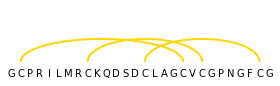

In [41]:
sequence = seq.ProteinSequence(knottin.res_name[knottin.atom_name == "CA"])
figure = plt.figure(figsize=(4.0, 1.3))
ax = figure.gca()
MARGIN = 0.2
ax.set_xlim(1-MARGIN, len(sequence)+MARGIN)
ax.set_ylim(0, 1+MARGIN)
ax.set_xticks(np.arange(1, len(sequence)+1))
ax.set_xticklabels(str(sequence))
ax.yaxis.set_tick_params(
    left=False, right=False, labelleft=False, labelright=False
)
ax.xaxis.set_tick_params(
    bottom=True, top=False, labelbottom=True, labeltop=False, width=0
)
ax.set_frame_on(False)
for sg1_index, sg2_index in disulfide_bonds:
    sg1_res_id = knottin.res_id[sg1_index]
    sg2_res_id = knottin.res_id[sg2_index]
    ellipse_center = (sg1_res_id + sg2_res_id) / 2
    ellipse_width = sg2_res_id - sg1_res_id
    # Height is 2 instead of 1,
    # because only the upper half of the ellipse is visible
    ax.add_patch(patches.Ellipse(
        xy=(ellipse_center, 0), width=ellipse_width, height=1,
        facecolor="None", edgecolor="gold", linewidth=2
    ))
figure.tight_layout()

In [19]:
biotite.colors

OrderedDict([('brightorange', '#ffb569ff'),
             ('lightorange', '#ff982dff'),
             ('orange', '#ff8405ff'),
             ('dimorange', '#dc7000ff'),
             ('darkorange', '#b45c00ff'),
             ('brightgreen', '#98e97fff'),
             ('lightgreen', '#6fe04cff'),
             ('green', '#52da2aff'),
             ('dimgreen', '#45bc20ff'),
             ('darkgreen', '#389a1aff')])

In [42]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow
import biotite
import biotite.structure.io.pdbx as pdbx
import biotite.database.rcsb as rcsb


##### OPTIONS #####
PDB_ID = "3AKO"
SHEETS = ["A"]

FIG_SIZE = (8.0, 4.0)           # Figure size in inches
Y_LIMIT = 2.0                   # Vertical plot limits
SHEET_DISTANCE = 3.0            # Separation of strands in different sheets
ARROW_TAIL_WITH = 0.4           # Width of the arrow tails
ARROW_HEAD_WITH = 0.7           # Width of the arrow heads
ARROW_HEAD_LENGTH = 0.25        # Length of the arrow heads
ARROW_LINE_WIDTH = 1            # Width of the arrow edges
ARROW_COLORS = [                # Each chain is colored differently
    biotite.colors["lightgreen"],
    biotite.colors["dimgreen"],
    biotite.colors["lightgreen"],
    biotite.colors["brightorange"],
]
CONNECTION_COLOR = "black"      # Color of the connection lines
CONNECTION_LINE_WIDTH = 1.5     # Width of the connection lines
CONNECTION_HEIGHT = 0.1         # Minimum height of the connection lines
CONNECTION_SEPARATION = 0.1     # Minimum vertical distance between the connection lines
RES_ID_HEIGHT = -0.2            # The vertical distance of the residue ID labels from the arrow ends
RES_ID_FONT_SIZE = 8            # The font size of the residue ID labels
RES_ID_FONT_WEIGHT = "bold"     # The font weight of the residue ID labels
ADAPTIVE_ARROW_LENGTHS = True   # If true, the arrow length is proportional to the number of its residues
SHOW_SHEET_NAMES = True        # If true, the sheets are labeled below the plot
SHEET_NAME_FONT_SIZE = 14       # The font size of the sheet labels
##### SNOITPO #####

In [43]:
pdbx_file = pdbx.PDBxFile.read(rcsb.fetch(PDB_ID, "pdbx"))
sheet_order_dict = pdbx_file["struct_sheet_order"]

# Create a boolean mask that covers the selected sheets
# or all sheets if none is given
if SHEETS is None:
    sele = np.full(len(sheet_order_dict["sheet_id"]), True)
else:
    sele = np.array([
        sheet in SHEETS for sheet in sheet_order_dict["sheet_id"]
    ])
sheet_ids = sheet_order_dict["sheet_id"][sele]

is_parallel_list = sheet_order_dict["sense"][sele] == "parallel"

adjacent_strands = np.array([
    (strand_i, strand_j) for strand_i, strand_j in zip(
        sheet_order_dict["range_id_1"][sele],
        sheet_order_dict["range_id_2"][sele]
    )
])

print("Adjacent strands (sheet ID, strand ID):")
for sheet_id, (strand_i, strand_j) in zip(sheet_ids, adjacent_strands):
    print(f"{sheet_id, strand_i} <-> {sheet_id, strand_j}")

Adjacent strands (sheet ID, strand ID):
('A', '1') <-> ('A', '2')
('A', '2') <-> ('A', '3')
('A', '3') <-> ('A', '4')
('A', '4') <-> ('A', '5')
('A', '5') <-> ('A', '6')
('A', '6') <-> ('A', '7')
('A', '7') <-> ('A', '8')
('A', '8') <-> ('A', '9')
('A', '9') <-> ('A', '10')
('A', '10') <-> ('A', '11')
('A', '11') <-> ('A', '12')


In [44]:
sheet_range_dict = pdbx_file["struct_sheet_range"]

# Again, create a boolean mask that covers the selected sheets
sele = np.array([
    sheet in sheet_ids for sheet in sheet_range_dict["sheet_id"]
])
strand_chain_ids = sheet_range_dict["beg_auth_asym_id"][sele]
strand_res_id_begs = sheet_range_dict["beg_auth_seq_id"].astype(int)[sele]
strand_res_id_ends = sheet_range_dict["end_auth_seq_id"].astype(int)[sele]

# Secondarily sort by residue ID
order = np.argsort(strand_res_id_begs, kind="stable")
# Primarily sort by chain ID
order = order[np.argsort(strand_chain_ids[order], kind="stable")]

sorted_strand_ids = sheet_range_dict["id"][sele][order]
sorted_sheet_ids = sheet_range_dict["sheet_id"][sele][order]
sorted_chain_ids = strand_chain_ids[order]
sorted_res_id_begs = strand_res_id_begs[order]
sorted_res_id_ends = strand_res_id_ends[order]

# Remove duplicate entries,
# i.e. entries with the same chain ID and residue ID
# Duplicate entries appear e.g. in beta-barrel structure files
# Draw one of each duplicate as orphan -> no connections
non_duplicate_mask = (np.diff(strand_res_id_begs[order], prepend=[-1]) != 0)
connections = []
non_duplicate_indices =  np.arange(len(sorted_strand_ids))[non_duplicate_mask]
for i in range(len(non_duplicate_indices) - 1):
    current_i = non_duplicate_indices[i]
    next_i = non_duplicate_indices[i+1]
    if sorted_chain_ids[current_i] != sorted_chain_ids[next_i]:
        # No connection between separate chains
        continue
    connections.append((
        (sorted_sheet_ids[current_i], sorted_strand_ids[current_i]),
        (sorted_sheet_ids[next_i],    sorted_strand_ids[next_i]   )
    ))

print("Connected strands (sheet ID, strand ID):")
for strand_i, strand_j in connections:
    print(f"{strand_i} -> {strand_j}")

# Save the start and end residue IDs for each strand for labeling
ranges = {
    (sheet_id, strand_id): (begin, end)
    for sheet_id, strand_id, begin, end
    in zip(
        sorted_sheet_ids, sorted_strand_ids,
        sorted_res_id_begs, sorted_res_id_ends
    )
}

# Save the chains ID for each strand for coloring
chain_ids = {
    (sheet_id, strand_id): chain_id
    for sheet_id, strand_id, chain_id
    in zip(sorted_sheet_ids, sorted_strand_ids, sorted_chain_ids)
}

unique_chain_ids = np.unique(sorted_chain_ids)

Connected strands (sheet ID, strand ID):
('A', '1') -> ('A', '2')
('A', '2') -> ('A', '3')
('A', '3') -> ('A', '9')
('A', '9') -> ('A', '10')
('A', '10') -> ('A', '11')
('A', '11') -> ('A', '6')
('A', '7') -> ('A', '8')
('A', '8') -> ('A', '5')
('A', '5') -> ('A', '4')


In [45]:
sheet_graphs = {}
for sheet_id in np.unique(sheet_ids):
    # Select only strands from the current sheet
    sheet_mask = (sheet_ids == sheet_id)
    sheet_graphs[sheet_id] = nx.Graph([
        (strand_i, strand_j, {"is_parallel": is_parallel})
        for (strand_i, strand_j), is_parallel in zip(
            adjacent_strands[sheet_mask],
            is_parallel_list[sheet_mask]
        )
    ])

In [46]:
for graph in sheet_graphs.values():
    initial_strand = adjacent_strands[0,0]
    graph.nodes[initial_strand]["is_upwards"] = True
    for strand in graph.nodes:
        if strand == initial_strand:
            continue
        this_strand_is_upwards = []
        for adj_strand in graph.neighbors(strand):
            is_upwards = graph.nodes[adj_strand].get("is_upwards")
            if is_upwards is None:
                # The arrow direction for this adjacent strand is not
                # yet determined
                continue
            is_parallel = graph.edges[(strand, adj_strand)]["is_parallel"]
            this_strand_is_upwards.append(
                is_upwards ^ ~is_parallel
            )
        if len(this_strand_is_upwards) == 0:
            raise ValueError(
                "Cannot determine arrow direction from adjacent strands"
            )
        elif all(this_strand_is_upwards):
            graph.nodes[strand]["is_upwards"] = True
        elif not any(this_strand_is_upwards):
            graph.nodes[strand]["is_upwards"] = False
        else:
            raise ValueError(
                "Conflicting arrow directions from adjacent strands"
            )

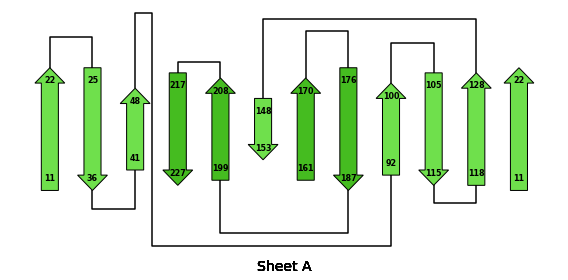

In [47]:
fig, ax = plt.subplots(figsize=FIG_SIZE)

### Plot arrows
MAX_ARROW_LENGTH = 2 # from y=-1 to y=1
arrow_length_per_seq_length = MAX_ARROW_LENGTH / np.max(
    [end - beg + 1 for beg, end in ranges.values()]
)
# The coordinates of the arrow ends are stored in this dictionary
# for each strand, accessed via a tuple of sheet and strand ID
coord_dict = {}
current_position = 0
# Plot each sheet separately,
# the start position of each sheet is given by 'current_position'
for sheet_id, graph in sheet_graphs.items():
    # Use *NetworkX*'s layouting algorithm to find the arrow positions
    # As we arrange the sheets along the x-axis,
    # there is only one dimension
    positions = nx.kamada_kawai_layout(graph, dim=1)
    strand_ids = np.array(list(positions.keys()))
    positions = np.array(list(positions.values()))
    # Each position has only one dimension
    # -> Remove the last dimension
    positions = positions[:, 0]
    # Transform positions to achieve a spacing of at least 1.0
    dist_matrix = np.abs(positions[:, np.newaxis] - positions[np.newaxis, :])
    positions /= np.min(dist_matrix[dist_matrix != 0])
    # Transform positions, so that they start at 'current_position'
    positions -= np.min(positions)
    positions += np.min(current_position)
    current_position = np.max(positions) + SHEET_DISTANCE

    # Draw an arrow for each strand
    for strand_id, pos in zip(strand_ids, positions):
        chain_id = chain_ids[sheet_id, strand_id]
        color_index = unique_chain_ids.tolist().index(chain_id)
        if ADAPTIVE_ARROW_LENGTHS:
            beg, end = ranges[sheet_id, strand_id]
            seq_length = end - beg + 1
            arrow_length = arrow_length_per_seq_length * seq_length
        else:
            arrow_length = MAX_ARROW_LENGTH
        if graph.nodes[strand_id]["is_upwards"]:
            y = -arrow_length / 2
            dy = arrow_length
        else:
            y = arrow_length / 2
            dy = -arrow_length
        ax.add_patch(
            FancyArrow(
                x=pos, y=y, dx=0, dy=dy,
                length_includes_head=True,
                width = ARROW_TAIL_WITH,
                head_width = ARROW_HEAD_WITH,
                head_length = ARROW_HEAD_LENGTH,
                facecolor = ARROW_COLORS[color_index % len(ARROW_COLORS)],
                edgecolor = CONNECTION_COLOR,
                linewidth = ARROW_LINE_WIDTH,
            )
        )
        # Start and end coordinates of the respective arrow
        coord_dict[sheet_id, strand_id] = ((pos, y), (pos, y + dy))

### Plot connections
# Each connection is plotted on a different height in order to keep them
# separable
# Plot the short connections at low height
# to decrease line intersections
# -> sort connections by length of connection
order = np.argsort([
    np.abs(coord_dict[strand_i][0][0] - coord_dict[strand_j][0][0])
    for strand_i, strand_j in connections
])
connections = [connections[i] for i in order]
for i, (strand_i, strand_j) in enumerate(connections):
    horizontal_line_height = 1 + CONNECTION_HEIGHT + i * CONNECTION_SEPARATION
    coord_i_beg, coord_i_end = coord_dict[strand_i]
    coord_j_beg, coord_j_end = coord_dict[strand_j]

    if np.sign(coord_i_end[1]) == np.sign(coord_j_beg[1]):
        # Start and end are on the same side of the arrows
        x = (
            coord_i_end[0],
            coord_i_end[0],
            coord_j_beg[0],
            coord_j_beg[0]
        )
        y = (
            coord_i_end[1],
            np.sign(coord_i_end[1]) * horizontal_line_height,
            np.sign(coord_j_beg[1]) * horizontal_line_height,
            coord_j_beg[1]
        )
    else:
        # Start and end are on different sides
        offset = 0.4 if coord_j_beg[0] >= coord_i_end[0] else -0.4
        x = (
            coord_i_end[0],
            coord_i_end[0],
            coord_i_end[0] + offset,
            coord_i_end[0] + offset,
            coord_j_beg[0],
            coord_j_beg[0]
        )
        y = (
            coord_i_end[1],
            np.sign(coord_i_end[1]) * horizontal_line_height,
            np.sign(coord_i_end[1]) * horizontal_line_height,
            np.sign(coord_j_beg[1]) * horizontal_line_height,
            np.sign(coord_j_beg[1]) * horizontal_line_height,
            coord_j_beg[1]
        )
    ax.plot(
        x, y,
        color = CONNECTION_COLOR,
        linewidth = CONNECTION_LINE_WIDTH,
        # Avoid intersection of the line's end with the arrow
        solid_capstyle = "butt"
    )

### Plot residue ID labels
for strand, (res_id_beg, res_id_end) in ranges.items():
    coord_beg, coord_end = coord_dict[strand]
    for coord, res_id in zip((coord_beg, coord_end), (res_id_beg, res_id_end)):
        ax.text(
            coord[0],
            np.sign(coord[1]) * (np.abs(coord[1]) + RES_ID_HEIGHT),
            str(res_id),
            ha="center", va="center",
            fontsize=RES_ID_FONT_SIZE, weight=RES_ID_FONT_WEIGHT
        )

### Plot sheet names as x-axis ticks
if SHOW_SHEET_NAMES:
    tick_pos = [
        np.mean([
            coord_dict[key][0][0] for key in coord_dict if key[0] == sheet_id
        ])
        for sheet_id in sheet_ids
    ]
    ax.set_xticks(tick_pos)
    ax.set_xticklabels([f"Sheet {sheet_id}" for sheet_id in sheet_ids])
    ax.set_frame_on(False)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_tick_params(
        bottom=False, top=False, labelbottom=True, labeltop=False,
        labelsize=SHEET_NAME_FONT_SIZE
    )
else:
    ax.axis("off")


ax.set_xlim(-1, current_position - SHEET_DISTANCE + 1)
ax.set_ylim(-Y_LIMIT, Y_LIMIT)
fig.tight_layout()

plt.show()

Rotatable bonds in tyrosine:
CA <-> CB
CB <-> CG


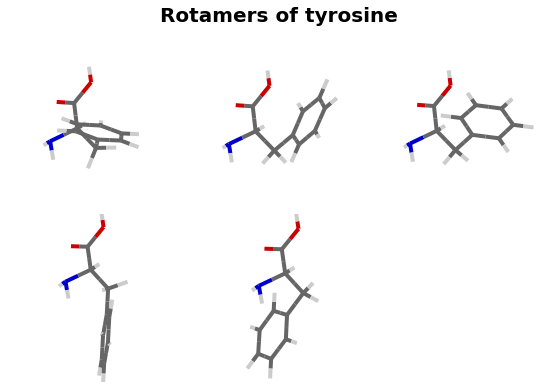

In [31]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import biotite.structure as struc
import biotite.structure.io as strucio
import biotite.structure.info as info
import biotite.structure.graphics as graphics


# 'CA' is not in backbone,
# as we want to include the rotation between 'CA' and 'CB'
BACKBONE = ["N", "C", "O", "OXT"]
LIBRARY_SIZE = 5


# Get the structure (including bonds) from the standard RCSB compound
residue = info.residue("PHE")
bond_list = residue.bonds


### Identify rotatable bonds ###
rotatable_bonds = struc.find_rotatable_bonds(residue.bonds)
# Do not rotate about backbone bonds,
# as these are irrelevant for a amino rotamer library
for atom_name in BACKBONE:
    index = np.where(residue.atom_name == atom_name)[0][0]
    rotatable_bonds.remove_bonds_to(index)
print("Rotatable bonds in tyrosine:")
for atom_i, atom_j, _ in rotatable_bonds.as_array():
    print(residue.atom_name[atom_i] + " <-> " + residue.atom_name[atom_j])


### VdW radii of each atom, required for the next step ###
vdw_radii = np.zeros(residue.array_length())
for i, element in enumerate(residue.element):
    vdw_radii[i] = info.vdw_radius_single(element)
# The Minimum required distance between two atoms is mean of their
# VdW radii
vdw_radii_mean = (vdw_radii[:, np.newaxis] + vdw_radii[np.newaxis, :]) / 2


### Rotate randomly about bonds ###
np.random.seed(0)
rotamer_coord = np.zeros((LIBRARY_SIZE, residue.array_length(), 3))
for i in range(LIBRARY_SIZE):
    # Coordinates for the current rotamer model
    coord = residue.coord.copy()
    for atom_i, atom_j, _ in rotatable_bonds.as_array():
        # The bond axis
        axis = coord[atom_j] - coord[atom_i]
        # Position of one of the involved atoms
        support = coord[atom_i]

        # Only atoms at one side of the rotatable bond should be moved
        # So the original Bondist is taken...
        bond_list_without_axis = residue.bonds.copy()
        # ...the rotatable bond is removed...
        bond_list_without_axis.remove_bond(atom_i, atom_j)
        # ...and these atoms are found by identifying the atoms that
        # are still connected to one of the two atoms involved
        rotated_atom_indices = struc.find_connected(
            bond_list_without_axis, root=atom_i
        )

        accepted = False
        while not accepted:
            # A random angle between 0 and 360 degrees
            angle = np.random.rand() * 2*np.pi
            # Rotate
            coord[rotated_atom_indices] = struc.rotate_about_axis(
                coord[rotated_atom_indices], axis, angle, support
            )

            # Check if the atoms clash with each other:
            # The distance between each pair of atoms must be larger
            # than the sum of their VdW radii, if they are not bonded to
            # each other
            accepted = True
            distances = struc.distance(
                coord[:, np.newaxis], coord[np.newaxis, :]
            )
            clashed = distances < vdw_radii_mean
            for clash_atom1, clash_atom2 in zip(*np.where(clashed)):
                if clash_atom1 == clash_atom2:
                    # Ignore distance of an atom to itself
                    continue
                if (clash_atom1, clash_atom2) not in bond_list:
                    # Nonbonded atoms clash
                    # -> structure is not accepted
                    accepted = False
    rotamer_coord[i] = coord
rotamers = struc.from_template(residue, rotamer_coord)


### Superimpose backbone onto first model for better visualization ###
rotamers, _ = struc.superimpose(
    rotamers[0], rotamers, atom_mask=struc.filter_backbone(rotamers)
)


### Visualize rotamers ###
colors = np.zeros((residue.array_length(), 3))
colors[residue.element == "H"] = (0.8, 0.8, 0.8) # gray
colors[residue.element == "C"] = (0.4, 0.4, 0.4) # green
colors[residue.element == "N"] = (0.0, 0.0, 0.8) # blue
colors[residue.element == "O"] = (0.8, 0.0, 0.0) # red

# For consistency, each subplot has the same box size
coord = rotamers.coord
size = np.array(
    [coord[:, :, 0].max() - coord[:, :, 0].min(),
     coord[:, :, 1].max() - coord[:, :, 1].min(),
     coord[:, :, 2].max() - coord[:, :, 2].min()]
).max() * 0.5

fig = plt.figure(figsize=(8.0, 8.0))
fig.suptitle("Rotamers of tyrosine", fontsize=20, weight="bold")
for i, rotamer in enumerate(rotamers):
    ax = fig.add_subplot(3, 3, i+1, projection="3d")
    graphics.plot_atoms(ax, rotamer, colors, line_width=4, size=size, zoom=0.9)

fig.tight_layout()
plt.show()

